# Notebook for download GO and select 1000 terms for the analysis 

## Step1: Dowload and process GO_BP terms 

In [ ]:
### this function will download go-basic.obo and parse it filtering for biological process branch
# it will output these two files that will be used in the next step:
# collapsed_go.symbol (a network format of GO terms)
# goID_2_name.tab (a mapping of GO terms to their names)

outdir = 'data/GO_BP/'
namespace = 'biological_process'

%run process_the_gene_ontology.py $outdir --namespace $namespace 

In [1]:
import networkx as nx
import pandas as pd
# function specific to loading the collapsed_go.symbol type file
def load_go(filename): 
    # Create an empty directed graph
    G = nx.DiGraph()

    with open(filename, 'r') as f:
        for line in f:
            columns = line.strip().split('\t')  # tab-separated values
            if len(columns) >= 3:
                parent = columns[0] # based on collapsed_go.symbol, the first column is parent
                child = columns[1] # second column is child
                interaction = columns[2] # third column is interaction type
                # Add an edge to the graph
                G.add_edge(parent, child, interaction=interaction)

    # Get the set of all genes
    hiergeneset = set(n for n in G.nodes() if not n.startswith('GO:'))

    # Get term statistics
    df = get_termStats(G, hiergeneset)

    return df

def get_termStats(G, hiergeneset):
    clusters = list(set(list(G.nodes())) - hiergeneset) #
    tsize_list = []
    cgene_list = []
    for c in clusters:
        infoset = nx.descendants(G, c) # get all the descendants of the cluster
        cgeneset = infoset.intersection(hiergeneset) # get the genes that are in the cluster
        tsize_list.append(len(cgeneset)) 
        cgene_list.append(list(cgeneset))

    df = pd.DataFrame(index=clusters)
    df['Genes'] = [' '.join(genes) for genes in cgene_list] # convert list to string separated by space
    df['Gene_Count'] = tsize_list # number of genes in the cluster
    return df


In [4]:
## use case
## GO version: Oct 07 2022

go_terms = load_go('./data/GO_BP/collapsed_go.symbol')
go_terms = go_terms.reset_index().rename(columns={'index': 'GO'}) # rename the index column to column name GO
print(go_terms.shape)

# add the go term description
term_des = pd.read_table('./data/GO_BP/goID_2_name.tab',
                                        header=None,
                                        names=['Term', 'Term_Description'],
                                        index_col=0)
go_terms_des = go_terms.merge(term_des, left_on='GO', right_index=True, how='left')

# check if there are any missing values
print(go_terms_des.isnull().sum())

go_terms_des.to_csv('data/go_terms.csv')
go_terms_des.head()

(12214, 3)
GO                  0
Genes               0
Gene_Count          0
Term_Description    0
dtype: int64


,GO,Genes,Gene_Count,Term_Description
0,GO:0042157,MPPE1 ZDHHC21 GOLGA7 NMT1 CWH43 PIGH ZDHHC7 PI...,140,lipoprotein metabolic process
1,GO:1901621,CDK20 PRKACA SUFU GPR161 TULP3 PRKACB,6,negative regulation of smoothened signaling pa...
2,GO:0007440,SMAD3 CTNNB1 NOTCH1 SOX17 FOXF1 SHH GATA4 SMAD...,10,foregut morphogenesis
3,GO:0051154,XBP1 TOMM70 BHLHE41 PI16 EZH2 TMEM119 GSK3A CC...,37,negative regulation of striated muscle cell di...
4,GO:0090181,DGAT2 NR1H4 CYP7A1 LPCAT3 ABCA2 SOD1 SEC14L2 C...,35,regulation of cholesterol metabolic process


## Step 2: Understand GO size distribution and select 1000 GO 

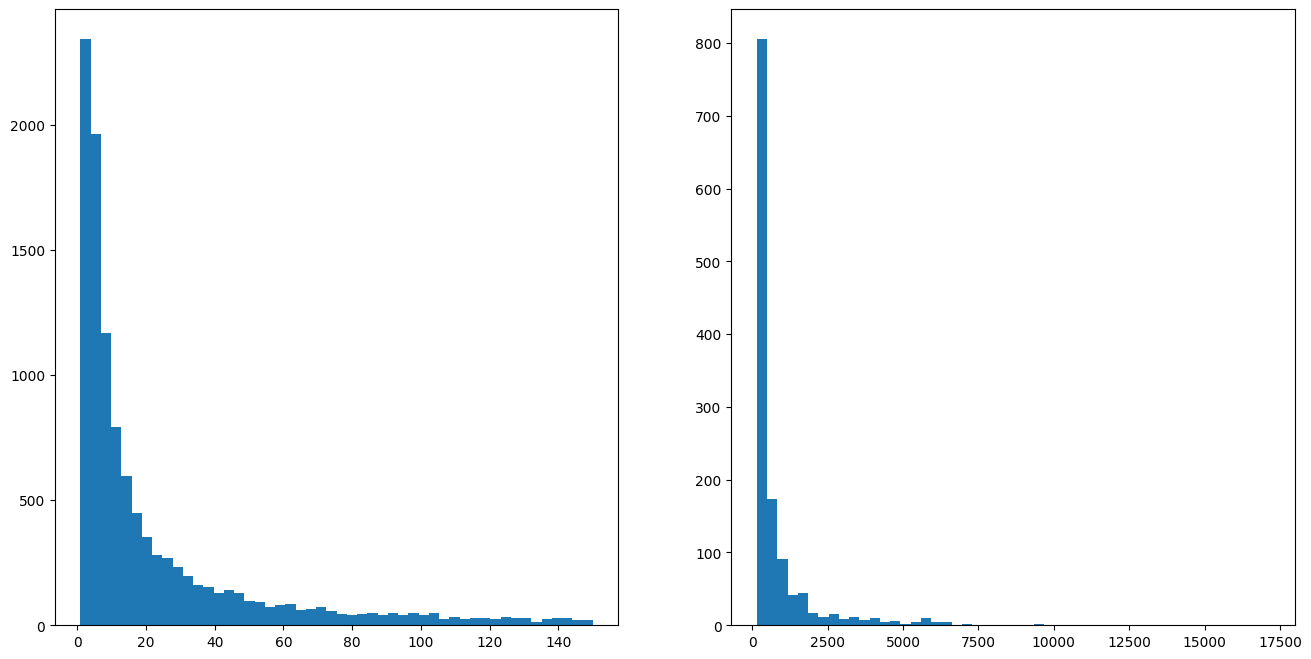

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
go_terms = pd.read_csv('data/go_terms.csv', sep = ',',index_col=0)

# subplots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8))
ax1.hist(go_terms[(go_terms['Gene_Count'] <= 150)]['Gene_Count'], bins=50)
ax2.hist(go_terms[(go_terms['Gene_Count'] > 150)]['Gene_Count'], bins=50)
plt.show()


In [3]:
# consider GO terms with gene counts >=3, check stats
go_filtered = go_terms[(go_terms['Gene_Count'] >= 3)]

go_filtered['Gene_Count'].describe()

count    10850.000000
mean       127.219171
std        598.015701
min          3.000000
25%          6.000000
50%         15.000000
75%         53.000000
max      17145.000000
Name: Gene_Count, dtype: float64

In [24]:
# if we randomly select GO terms between 3-100, what percentage of terms will be in the pool?
go_terms[(go_terms['Gene_Count'] >= 3) & (go_terms['Gene_Count'] <= 150)].shape[0]/go_terms.shape[0]



0.7826264941869985

In [ ]:
# Based on the distribution of GO terms, randomly pick 500 from the 3-15 bin (15 is the 50% quantile), 250 from the 16-53 bin (around 75% quantile), and another 250 from the 54-500 bin (avoiding large gene sets)
## avoid picking the same gene set twice and avoid the ones already in the 25 gene sets
import pandas as pd

go_terms = pd.read_csv('data/go_terms.csv', sep = ',',index_col=0)

# chosen_go_terms = pd.read_csv('data/genesets-subset/0530_selected_go_terms_within100.csv', sep = ',',index_col=0)


def select_go_terms(go_terms, low, high, n, skip_terms = []):
    go_terms_range = go_terms[(go_terms['Gene_Count'] >= low) & (go_terms['Gene_Count'] < high)]
    if skip_terms:
        go_terms_range = go_terms_range[~go_terms_range['GO'].isin(skip_terms)]
        # print(len(go_terms_range))
        n_new = n - len(skip_terms)
        # print(n_new)
        selected_go = go_terms_range.sample(n=n_new, random_state=1)
    else:
        selected_go = go_terms_range.sample(n=n, random_state=1)
    return selected_go

selected_go_terms = []
# skip_less20 = chosen_go_terms[chosen_go_terms['Gene_Count'] < 20]['GO'].tolist()
# skip_20to100 = chosen_go_terms[(chosen_go_terms['Gene_Count'] >= 20) & (chosen_go_terms['Gene_Count'] < 100)]['GO'].tolist()
# print(len(skip_20to100), len(skip_less20))
selected_go_terms.append(select_go_terms(go_terms, 3, 16, 500))
selected_go_terms.append(select_go_terms(go_terms, 16, 54, 250))
selected_go_terms.append(select_go_terms(go_terms, 54, 501, 250))



df_selected_go_terms = pd.concat(selected_go_terms)
print(len(df_selected_go_terms))
df_selected_go_terms.to_csv('data/GO_term_analysis/1000_selected_go_terms.csv', index=False)

# df_selected_go_terms.to_csv('data/GO_term_analysis/0531_selected_go_terms.csv', index=False)
# ##combine with the 25 gene sets
# df_selected_go_terms_all = pd.concat([df_selected_go_terms, chosen_go_terms])
# print(len(df_selected_go_terms_all))
# df_selected_go_terms_all.to_csv('data/GO_term_analysis/1000_selected_go_terms.csv', index=False)


In [ ]:
df_selected_go_terms.head()

,GO,Genes,Gene_Count,Term_Description
5700,GO:0032385,LDLRAP1 SCP2D1 ANXA2 SCP2,4,positive regulation of intracellular cholester...
12149,GO:0002468,NOD1 HLA-DRA CLEC4A HLA-DRB1 CCL21 NOD2 CCL19 ...,15,dendritic cell antigen processing and presenta...
1314,GO:0033683,OGG1 ERCC5 XPA ERCC4 NTHL1,5,"nucleotide-excision repair, DNA incision"
11210,GO:0035672,SLC7A11 SLC25A39 SLC26A6 ABCB9 SLC15A4 ABCC5 C...,15,oligopeptide transmembrane transport
8889,GO:0048023,OPN3 CDH3 ATP7A APPL1 ASIP RAB38 ZEB2 TYRP1 GIPC1,9,positive regulation of melanin biosynthetic pr...


In [2]:
# extract a subset of 10 GO terms as a toy example
import pandas as pd
df = pd.read_csv('data/GO_term_analysis/1000_selected_go_terms.csv')
# take first 10 as a toy example
df = df.iloc[:10]
df.to_csv('data/GO_term_analysis/toy_example.csv', index=False)
